In [141]:
# Importing required libraries

# Keras
import keras
from keras import regularizers
from keras_preprocessing import sequence
from keras_preprocessing.sequence import pad_sequences
from keras import Sequential, Model
from keras._tf_keras.keras.models import model_from_json
from keras._tf_keras.keras.layers import Dense, Embedding, LSTM, Input, Flatten, Dropout, Activation, \
    BatchNormalization, Conv1D, MaxPooling1D, AveragePooling1D
from keras._tf_keras.keras.utils import to_categorical
from keras._tf_keras.keras.callbacks import ModelCheckpoint
from keras._tf_keras.keras import utils
from keras._tf_keras.keras import optimizers
import np_utils

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other
import librosa
from librosa import feature
import json
from scipy.io import wavfile
from python_speech_features import mfcc
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

import sys
import warnings


In [142]:

# Filter specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="librosa.core.audio")

# ignore general warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [143]:
# let's pick up the meta-data that we got from our first part of the Kernel
ref = pd.read_csv(r"C:\Users\eo19181\Documents\All -  Datasets\data_paths.csv")
print(ref.head())


         labels           source  \
0  female_angry  CREMA - Dataset   
1  female_angry  CREMA - Dataset   
2  female_angry  CREMA - Dataset   
3  female_angry  CREMA - Dataset   
4  female_angry  CREMA - Dataset   

                                                path  
0  C:\Users\eo19181\Documents\All -  Datasets\CRE...  
1  C:\Users\eo19181\Documents\All -  Datasets\CRE...  
2  C:\Users\eo19181\Documents\All -  Datasets\CRE...  
3  C:\Users\eo19181\Documents\All -  Datasets\CRE...  
4  C:\Users\eo19181\Documents\All -  Datasets\CRE...  


In [144]:
# Note this takes a couple of minutes (~10 mins) as we're iterating over 4 datasets
df = pd.DataFrame(columns=['feature'])

counter = 0
for index, path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  , duration=2.5
                                  , sr=44100
                                  , offset=0.5
                                  )
    sample_rate = np.array(sample_rate)

    # mean as the feature. Could do min and max etc as well.
    mfccs = np.mean(feature.mfcc(y=X,
                                         sr=sample_rate,
                                         n_mfcc=13),
                    axis=0)
    df.loc[counter] = [mfccs]
    counter = counter + 1

# Check a few records to make sure its processed successfully
print(len(df))
df.head()



29662


,feature
0,"[-8.735706, -11.802475, -14.745775, -17.718931..."
1,"[-22.989948, -20.110119, -20.15562, -20.035357..."
2,"[-22.394182, -20.416922, -18.989695, -20.71952..."
3,"[-23.670723, -22.904083, -22.577242, -19.74844..."
4,"[-20.517, -20.450459, -21.32946, -21.049713, -..."


In [145]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,female_angry,CREMA - Dataset,C:\Users\eo19181\Documents\All - Datasets\CRE...,-8.735706,-11.802475,-14.745775,-17.718931,-16.918413,-17.892012,-18.135666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,female_angry,CREMA - Dataset,C:\Users\eo19181\Documents\All - Datasets\CRE...,-22.989948,-20.110119,-20.155621,-20.035357,-19.782257,-19.721539,-20.604776,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,female_angry,CREMA - Dataset,C:\Users\eo19181\Documents\All - Datasets\CRE...,-22.394182,-20.416922,-18.989695,-20.719521,-21.506039,-21.809082,-24.855665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,female_angry,CREMA - Dataset,C:\Users\eo19181\Documents\All - Datasets\CRE...,-23.670723,-22.904083,-22.577242,-19.748447,-20.110104,-19.088276,-19.384001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,female_angry,CREMA - Dataset,C:\Users\eo19181\Documents\All - Datasets\CRE...,-20.517000,-20.450459,-21.329460,-21.049713,-19.984964,-21.225258,-21.733809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(29662, 219)


,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,female_angry,CREMA - Dataset,C:\Users\eo19181\Documents\All - Datasets\CRE...,-8.735706,-11.802475,-14.745775,-17.718931,-16.918413,-17.892012,-18.135666,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,female_angry,CREMA - Dataset,C:\Users\eo19181\Documents\All - Datasets\CRE...,-22.989948,-20.110119,-20.155621,-20.035357,-19.782257,-19.721539,-20.604776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,female_angry,CREMA - Dataset,C:\Users\eo19181\Documents\All - Datasets\CRE...,-22.394182,-20.416922,-18.989695,-20.719521,-21.506039,-21.809082,-24.855665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,female_angry,CREMA - Dataset,C:\Users\eo19181\Documents\All - Datasets\CRE...,-23.670723,-22.904083,-22.577242,-19.748447,-20.110104,-19.088276,-19.384001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,female_angry,CREMA - Dataset,C:\Users\eo19181\Documents\All - Datasets\CRE...,-20.517000,-20.450459,-21.329460,-21.049713,-19.984964,-21.225258,-21.733809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
1574,-21.541708,-18.238091,-15.992913,-13.391658,-12.539718,-14.067845,-15.857325,-15.265344,-15.057481,-16.604017,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6815,-18.556435,-19.359245,-23.060078,-22.867771,-19.908033,-19.302036,-17.971348,-14.545268,-15.434630,-20.113382,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1349,-21.717142,-17.478130,-15.674486,-17.007103,-19.860527,-19.128378,-20.249706,-20.063856,-18.548183,-18.617912,...,-18.464504,-17.989767,-17.877150,-17.394108,-17.573141,-19.891634,-20.186819,-18.433815,-18.485394,-17.811062
9198,-16.808176,-20.177380,-29.375959,-28.917044,-27.623766,-28.317881,-29.021965,-28.511665,-27.765108,-29.793545,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14049,-6.378090,-8.946508,-18.176296,-20.017027,-19.084129,-20.021877,-14.256145,-15.171856,-21.827684,-24.396646,...,-31.058353,-32.453854,-31.488585,-29.664818,-24.693129,-20.241089,-17.084906,-18.094067,-15.118465,-11.086040
24180,-17.756823,-15.904403,-16.577362,-17.339378,-19.016499,-19.195412,-20.259605,-20.238918,-19.871105,-19.243965,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8615,-3.437155,-6.916733,-15.708899,-14.700356,-15.497255,-15.969074,-15.091757,-16.389116,-18.392303,-20.459564,...,-27.066591,-28.596205,-30.235283,-29.677643,-32.611328,-37.057541,-34.756870,-30.185356,-30.072365,-32.936821
5071,-9.914087,-12.535627,-15.226973,-13.512239,-14.743846,-13.345675,-13.307417,-12.855549,-11.190795,-10.805943,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6127,-30.357027,-25.819826,-24.194847,-21.713144,-20.022533,-20.856243,-20.644489,-18.725872,-17.504307,-20.759228,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3223,-15.088490,-16.266384,-18.460661,-19.452044,-20.401142,-18.386372,-18.467014,-18.290958,-17.598749,-16.197948,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [148]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
1574,-0.101792,0.288248,0.935878,1.196038,1.275823,1.118021,0.931004,0.985002,1.001277,0.842865,...,0.642790,0.631078,0.626563,0.621599,0.610629,0.605859,0.600895,0.591614,0.579491,0.561715
6815,0.166722,0.179393,0.222638,0.242184,0.536766,0.594027,0.719877,1.056888,0.963602,0.492403,...,0.642790,0.631078,0.626563,0.621599,0.610629,0.605859,0.600895,0.591614,0.579491,0.561715
1349,-0.117571,0.362034,0.968015,0.832111,0.541531,0.611412,0.492338,0.505966,0.652570,0.641748,...,-0.504204,-0.488270,-0.485860,-0.461157,-0.486012,-0.636338,-0.659576,-0.560172,-0.595494,-0.581291
9198,0.323971,0.099958,-0.414780,-0.366729,-0.237137,-0.308547,-0.383746,-0.337381,-0.268165,-0.474304,...,0.642790,0.631078,0.626563,0.621599,0.610629,0.605859,0.600895,0.591614,0.579491,0.561715
14049,1.262115,1.190388,0.715525,0.529136,0.619405,0.521964,1.090914,0.994335,0.324961,0.064656,...,-1.286519,-1.388246,-1.332844,-1.224989,-0.930331,-0.658161,-0.465892,-0.538944,-0.381482,-0.149720
24180,0.238644,0.514831,0.876894,0.798665,0.626189,0.604701,0.491349,0.488489,0.520415,0.579227,...,0.642790,0.631078,0.626563,0.621599,0.610629,0.605859,0.600895,0.591614,0.579491,0.561715
8615,1.526641,1.387463,0.964542,1.064306,0.979176,0.927689,1.007461,0.872816,0.668142,0.457831,...,-1.038556,-1.148218,-1.254856,-1.225787,-1.424461,-1.708318,-1.569334,-1.294435,-1.331996,-1.551972
5071,0.944067,0.841913,1.013179,1.183900,1.054744,1.190317,1.185663,1.225573,1.387544,1.421888,...,0.642790,0.631078,0.626563,0.621599,0.610629,0.605859,0.600895,0.591614,0.579491,0.561715
6127,-0.894695,-0.447879,0.108114,0.358407,0.525282,0.438436,0.452911,0.639537,0.756849,0.427906,...,0.642790,0.631078,0.626563,0.621599,0.610629,0.605859,0.600895,0.591614,0.579491,0.561715
3223,0.478650,0.479685,0.686826,0.586007,0.487306,0.685694,0.670375,0.682955,0.747415,0.883417,...,0.642790,0.631078,0.626563,0.621599,0.610629,0.605859,0.600895,0.591614,0.579491,0.561715


In [149]:
max_data = np.max(X_train)
min_data = np.min(X_train)
X_train = (X_train-min_data)/(max_data-min_data+1e-6)
X_train =  X_train-0.5

max_data = np.max(X_test)
min_data = np.min(X_test)
X_test = (X_test-min_data)/(max_data-min_data+1e-6)
X_test =  X_test-0.5

X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
1574,0.110597,0.140919,0.191268,0.211493,0.217696,0.205428,0.190889,0.195087,0.196352,0.184037,...,0.168482,0.167572,0.167221,0.166835,0.165982,0.165611,0.165225,0.164504,0.163561,0.162179
6815,0.131471,0.132457,0.135819,0.137338,0.160240,0.164691,0.174475,0.200675,0.193423,0.156791,...,0.168482,0.167572,0.167221,0.166835,0.165982,0.165611,0.165225,0.164504,0.163561,0.162179
1349,0.109370,0.146656,0.193766,0.183201,0.160610,0.166043,0.156786,0.157845,0.169243,0.168401,...,0.079312,0.080551,0.080738,0.082658,0.080726,0.069039,0.067233,0.074961,0.072215,0.073319
9198,0.143696,0.126281,0.086264,0.090000,0.100074,0.094523,0.088677,0.092281,0.097662,0.081636,...,0.168482,0.167572,0.167221,0.166835,0.165982,0.165611,0.165225,0.164504,0.163561,0.162179
14049,0.216630,0.211054,0.174137,0.159647,0.166664,0.159089,0.203321,0.195812,0.143773,0.123537,...,0.018493,0.010584,0.014891,0.023276,0.046184,0.067343,0.082290,0.076611,0.088853,0.106870
24180,0.137063,0.158534,0.186682,0.180600,0.167192,0.165521,0.156709,0.156487,0.158969,0.163541,...,0.168482,0.167572,0.167221,0.166835,0.165982,0.165611,0.165225,0.164504,0.163561,0.162179
8615,0.237195,0.226375,0.193496,0.201252,0.194634,0.190631,0.196833,0.186365,0.170453,0.154103,...,0.037770,0.029244,0.020954,0.023214,0.007768,-0.014299,-0.003494,0.017877,0.014957,-0.002144
5071,0.191904,0.183963,0.197277,0.210550,0.200509,0.211049,0.210687,0.213789,0.226382,0.229052,...,0.168482,0.167572,0.167221,0.166835,0.165982,0.165611,0.165225,0.164504,0.163561,0.162179
6127,0.048954,0.083691,0.126915,0.146374,0.159347,0.152595,0.153721,0.168229,0.177350,0.151777,...,0.168482,0.167572,0.167221,0.166835,0.165982,0.165611,0.165225,0.164504,0.163561,0.162179
3223,0.155722,0.155802,0.171906,0.164068,0.156395,0.171818,0.170627,0.171605,0.176616,0.187189,...,0.168482,0.167572,0.167221,0.166835,0.165982,0.165611,0.165225,0.164504,0.163561,0.162179


In [150]:


# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()


(22246, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [151]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(22246, 216, 1)

In [152]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_72 (Conv1D)              │ (None, 216, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_81 (Activation)      │ (None, 216, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_73 (Conv1D)              │ (None, 216, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 216, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_82 (Activation)      │ (None, 216, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 216, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_74 (Conv1D)              │ (None, 27, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_83 (Activation)      │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_75 (Conv1D)              │ (None, 27, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_84 (Activation)      │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_76 (Conv1D)              │ (None, 27, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_85 (Activation)      │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_77 (Conv1D)              │ (None, 27, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 27, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_86 (Activation)      │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_78 (Conv1D)              │ (None, 3, 64)          │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_87 (Activation)      │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_79 (Conv1D)              │ (None, 3, 64)          │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_88 (Activation)      │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 14)             │         2,70

 Total params: 1,285,390 (4.90 MB)

 Trainable params: 1,284,622 (4.90 MB)

 Non-trainable params: 768 (3.00 KB)

In [153]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 49s 35ms/step - accuracy: 0.1248 - loss: 2.5211 - val_accuracy: 0.1899 - val_loss: 2.3539
Epoch 2/100
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 52s 37ms/step - accuracy: 0.2142 - loss: 2.2713 - val_accuracy: 0.2178 - val_loss: 2.2867
Epoch 3/100
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 56s 40ms/step - accuracy: 0.2380 - loss: 2.1807 - val_accuracy: 0.2149 - val_loss: 2.2679
Epoch 4/100
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 56s 40ms/step - accuracy: 0.2562 - loss: 2.1071 - val_accuracy: 0.2259 - val_loss: 2.2386
Epoch 5/100
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 56s 40ms/step - accuracy: 0.2704 - loss: 2.0710 - val_accuracy: 0.2249 - val_loss: 2.2131
Epoch 6/100
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 57s 41ms/step - accuracy: 0.2954 - loss: 1.9967 - val_accuracy: 0.2375 - val_loss: 2.1564
Epoch 7/100
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 55s 40ms/step - accuracy: 0.3029 - loss: 1.9572 - val_accuracy: 0.2435 - val_loss: 2.1487
Epoch 8/100
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 55s 40ms/step - accuracy: 

In [154]:
# # Ensure your labels are correctly encoded for 14 classes
# y_train_encoded = to_categorical(y_train, num_classes=14)
# y_test_encoded = to_categorical(y_test, num_classes=14)

In [96]:
# model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_test, y_test_encoded))

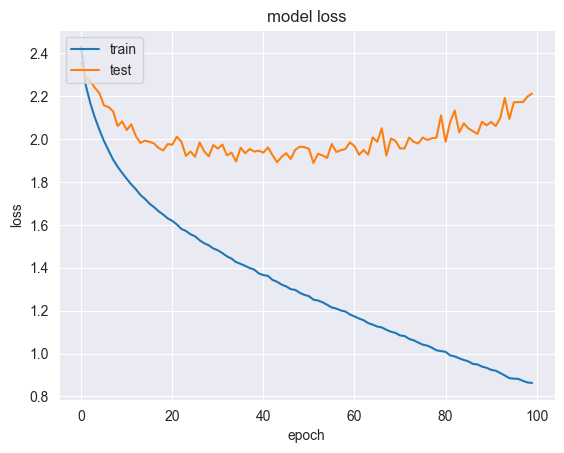

In [155]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [169]:
# Save model and weights
model_name = 'Emotion_Model (epoch 100).h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json (epoch 100).json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at C:\Users\eo19181\PycharmProjects\pythonProject\speech_emotion_analyser\saved_models\Emotion_Model (epoch 100).h5 


In [170]:
# loading json and model architecture 
json_file = open('model_json (epoch 100).json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model (epoch 100).h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
compile_metrics: 30.69%


In [158]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

464/464 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step


array([ 6,  5,  5, ...,  7, 10, 10], dtype=int64)

In [160]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

ValueError: invalid literal for int() with base 10: 'female_surprise'

In [161]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,1421
female_disgust,214
female_fear,412
female_happy,1204
female_neutral,401
female_sad,330
female_surprise,395
male_angry,994
male_disgust,89


In [162]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

0.3069039913700108


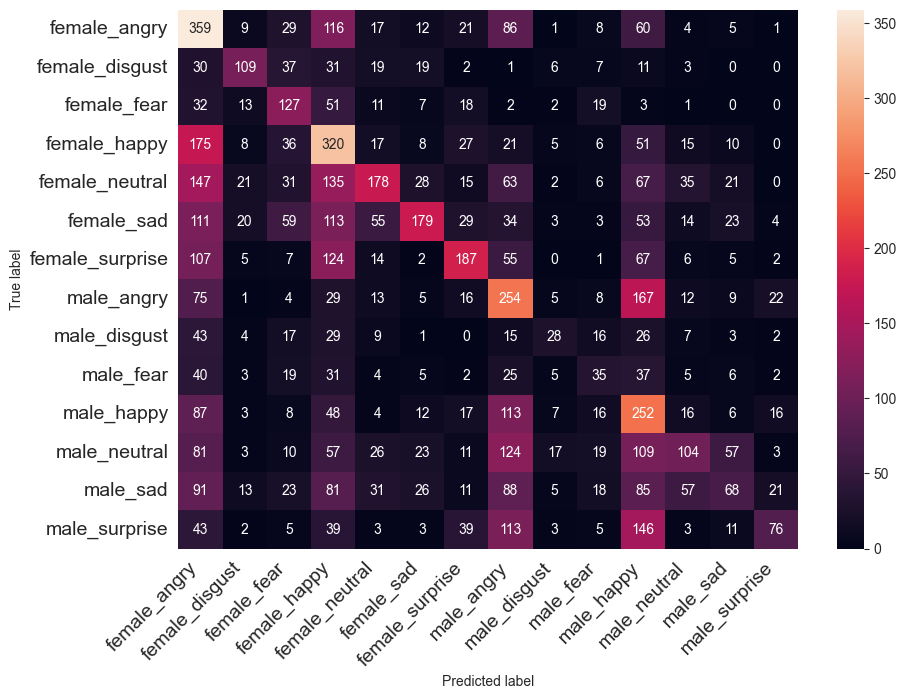

In [163]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [164]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.25      0.49      0.33       728
 female_disgust       0.51      0.40      0.45       275
    female_fear       0.31      0.44      0.36       286
   female_happy       0.27      0.46      0.34       699
 female_neutral       0.44      0.24      0.31       749
     female_sad       0.54      0.26      0.35       700
female_surprise       0.47      0.32      0.38       582
     male_angry       0.26      0.41      0.31       620
   male_disgust       0.31      0.14      0.19       200
      male_fear       0.21      0.16      0.18       219
     male_happy       0.22      0.42      0.29       605
   male_neutral       0.37      0.16      0.22       644
       male_sad       0.30      0.11      0.16       618
  male_surprise       0.51      0.15      0.24       491

       accuracy                           0.31      7416
      macro avg       0.36      0.30      0.29      7416
   weighted avg       0.36   

0.7381337648327939


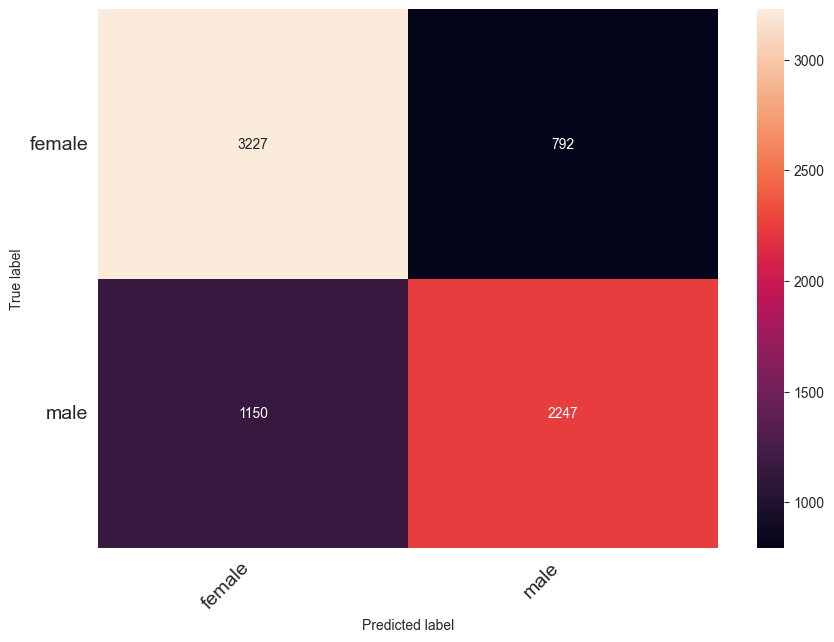

In [165]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [166]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.74      0.80      0.77      4019
        male       0.74      0.66      0.70      3397

    accuracy                           0.74      7416
   macro avg       0.74      0.73      0.73      7416
weighted avg       0.74      0.74      0.74      7416



0.36879719525350596


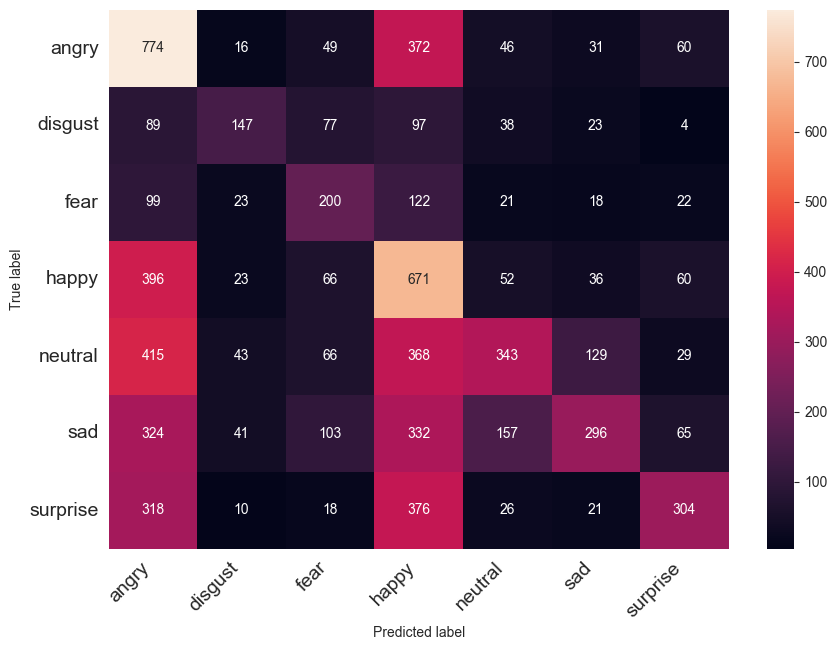

In [167]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [168]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.32      0.57      0.41      1348
     disgust       0.49      0.31      0.38       475
        fear       0.35      0.40      0.37       505
       happy       0.29      0.51      0.37      1304
     neutral       0.50      0.25      0.33      1393
         sad       0.53      0.22      0.32      1318
    surprise       0.56      0.28      0.38      1073

    accuracy                           0.37      7416
   macro avg       0.43      0.36      0.36      7416
weighted avg       0.43      0.37      0.36      7416

